# Coherence 
![Screenshot from 2019-11-15 18-08-00](https://user-images.githubusercontent.com/33189954/68930988-e97c8580-07d2-11ea-9f85-ab0927e1e712.png)

![Screenshot from 2019-11-15 18-08-50](https://user-images.githubusercontent.com/33189954/68931021-fe591900-07d2-11ea-9ffc-1e85364e2bfd.png)

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.


In [3]:
!pip install tqdm

In [4]:
import keras
import tensorflow as tf
import tqdm

In [5]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
label_list = [i for i in range(10)]

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

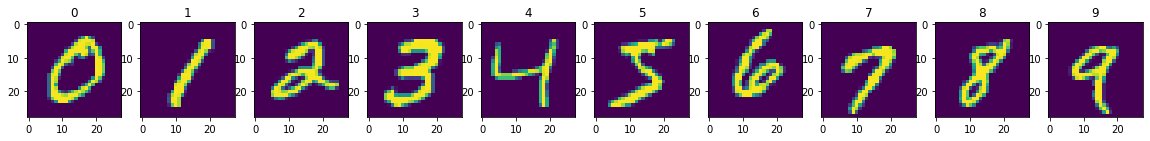

In [8]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord]])

plt.show()

In [9]:
model = keras.models.load_model('../models/mnist_gradcam.h5')

/home/jake/venv/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
model.compile(loss='categorical_crossentropy', 
          optimizer='adam', 
          metrics=['accuracy'])

In [17]:
def get_smoothgrad(img_input, saliency, n=10, sigma=1):
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    return result / n


In [11]:
def get_gradcam(img,model,idx,activation_layer):
    inp = model.input
    #y_c = model.output.op.inputs[0][0,class_index]
    
    #img_arr, img_tensor = preprocess_input(img)
    #print(img_arr.shape)
    
    # idx의 cnn마지막 layer op(softmax,linear) 의 입력 
    img_tensor = x_test[idx][np.newaxis,...,np.newaxis]/255.
    y_c = model.output[0, idx]
    
    #activation conv layer의 출력 feature map 
    A_k = model.get_layer(activation_layer).output
    
    
    grads = K.gradients(y_c, A_k)[0]
    gradient_fn = K.function([model.input], [A_k, grads, model.layers[-1].output])
    #print([img_tensor])
    conv_output, grad_val, predictions = gradient_fn([img_tensor])
    #conv_output, grad_val = conv_output[0], grad_val[0]
    
    conv_output = conv_output[0]
    grad_val = grad_val[0]
    
    #print(grad_val.shape)
    
    weights  = np.mean(grad_val,axis=(0,1))
    
    #print(weights)

    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, :, k]
    
    grad_cam = cv2.resize(grad_cam, (28, 28))

    ## ReLU를 씌워 음수를 0으로 만든다.
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = grad_cam / grad_cam.max()
    
    
    #img = cv2.imread(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.convert('L')
    img = cv2.resize(img, (28, 28))
    
    #print('grad-cam->', grad_cam.shape,'img_shape->',img.shape)
    
    plt.imshow(grad_cam, cmap="jet")
    plt.imshow(img, cmap="jet", alpha=.5)

    
    return img, grad_cam
    

In [12]:
batch_size = 100
iteration = 100
sigma = 1
isplot = False

tot_score = {i: [] for i in range(10)}

In [13]:
tot_score

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

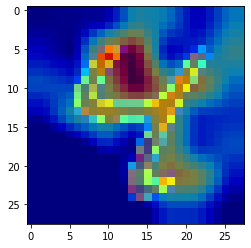

In [14]:
idx = 6
img,grad_cam=get_gradcam(x_test[idx], model, idx,"conv2d_33")

In [20]:
for label in range(10):
    print('***** label {} *****'.format(label))
    y_c = model.output[0, label]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    
    idx_coord = np.where(y_test == label)[0]
    X = np.zeros((batch_size, 28, 28, 1))
    for batch in range(batch_size):
        X[batch,...,0] = x_test[idx_coord[batch]]/255
        
    Y = np.array([[1 if label==i else 0 for i in range(10)] for _ in range(batch_size)])
    
    for batch in tqdm.trange(batch_size):
        x_input = X[batch,...,0].copy()
        y_input = Y[batch].copy()
        
        score_list = []
        if isplot:
            plt.figure(figsize=(30,30))
            
        for it in range(iteration):
            score = model.evaluate(x_input[np.newaxis,...,np.newaxis], y_input[np.newaxis,...], verbose=0)[1]
            score_list.append(score)
            
            #img, gradmap =get_gradcam(x_test[idx], model, idx,"conv2d_33")
            gradmap = np.abs(np.squeeze(get_smoothgrad(x_input[np.newaxis,...,np.newaxis], saliency, sigma=sigma)))

            
            if isplot:
                plt.subplot(1,20,2*(it%10)+1)
                plt.imshow(np.squeeze(x_input))
                plt.subplot(1,20,2*(it%10)+2)
                plt.imshow(np.squeeze(gradmap))
                if it%10 == 9:
                    plt.show()
                    plt.figure(figsize=(30,30))
            
            coord = np.where(gradmap == gradmap.max())
            x_input[coord] = 0.
        
        tot_score[label].append(score_list)

***** label 0 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:52,  1.74s/it]

  2%|▏         | 2/100 [00:03<02:49,  1.73s/it]

  3%|▎         | 3/100 [00:05<02:46,  1.72s/it]

  4%|▍         | 4/100 [00:06<02:44,  1.72s/it]

  5%|▌         | 5/100 [00:08<02:41,  1.70s/it]

  6%|▌         | 6/100 [00:10<02:40,  1.70s/it]

  7%|▋         | 7/100 [00:11<02:38,  1.70s/it]

  8%|▊         | 8/100 [00:13<02:36,  1.70s/it]

  9%|▉         | 9/100 [00:15<02:35,  1.71s/it]

 10%|█         | 10/100 [00:17<02:33,  1.71s/it]

 11%|█         | 11/100 [00:18<02:31,  1.71s/it]

 12%|█▏        | 12/100 [00:20<02:30,  1.71s/it]

 13%|█▎        | 13/100 [00:22<02:27,  1.69s/it]

 14%|█▍        | 14/100 [00:23<02:24,  1.68s/it]

 15%|█▌        | 15/100 [00:25<02:22,  1.67s/it]

 16%|█▌        | 16/100 [00:27<02:21,  1.68s/it]

 17%|█▋        | 17/100 [00:28<02:19,  1.68s/it]

 18%|█▊        | 18/100 [00:30<02:17,  1.68s/it]

 19%|█▉        | 19/100 [00:32<02:14,  1.66s/it]

 20%|██        |

***** label 1 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:49,  1.71s/it]

  2%|▏         | 2/100 [00:03<02:47,  1.71s/it]

  3%|▎         | 3/100 [00:05<02:46,  1.72s/it]

  4%|▍         | 4/100 [00:06<02:45,  1.72s/it]

  5%|▌         | 5/100 [00:08<02:44,  1.73s/it]

  6%|▌         | 6/100 [00:10<02:42,  1.73s/it]

  7%|▋         | 7/100 [00:12<02:39,  1.71s/it]

  8%|▊         | 8/100 [00:13<02:34,  1.68s/it]

  9%|▉         | 9/100 [00:15<02:31,  1.67s/it]

 10%|█         | 10/100 [00:16<02:29,  1.66s/it]

 11%|█         | 11/100 [00:18<02:26,  1.65s/it]

 12%|█▏        | 12/100 [00:20<02:25,  1.66s/it]

 13%|█▎        | 13/100 [00:21<02:25,  1.67s/it]

 14%|█▍        | 14/100 [00:23<02:25,  1.70s/it]

 15%|█▌        | 15/100 [00:25<02:25,  1.71s/it]

 16%|█▌        | 16/100 [00:27<02:23,  1.71s/it]

 17%|█▋        | 17/100 [00:28<02:23,  1.73s/it]

 18%|█▊        | 18/100 [00:30<02:20,  1.71s/it]

 19%|█▉        | 19/100 [00:32<02:18,  1.70s/it]

 20%|██        |

***** label 2 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:48,  1.70s/it]

  2%|▏         | 2/100 [00:03<02:46,  1.70s/it]

  3%|▎         | 3/100 [00:05<02:45,  1.71s/it]

  4%|▍         | 4/100 [00:06<02:45,  1.72s/it]

  5%|▌         | 5/100 [00:08<02:42,  1.71s/it]

  6%|▌         | 6/100 [00:10<02:38,  1.69s/it]

  7%|▋         | 7/100 [00:11<02:37,  1.69s/it]

  8%|▊         | 8/100 [00:13<02:32,  1.65s/it]

  9%|▉         | 9/100 [00:15<02:31,  1.66s/it]

 10%|█         | 10/100 [00:16<02:31,  1.68s/it]

 11%|█         | 11/100 [00:18<02:29,  1.68s/it]

 12%|█▏        | 12/100 [00:20<02:26,  1.66s/it]

 13%|█▎        | 13/100 [00:21<02:23,  1.65s/it]

 14%|█▍        | 14/100 [00:23<02:21,  1.65s/it]

 15%|█▌        | 15/100 [00:25<02:21,  1.66s/it]

 16%|█▌        | 16/100 [00:26<02:19,  1.66s/it]

 17%|█▋        | 17/100 [00:28<02:17,  1.65s/it]

 18%|█▊        | 18/100 [00:30<02:16,  1.67s/it]

 19%|█▉        | 19/100 [00:31<02:16,  1.69s/it]

 20%|██        |

***** label 3 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:53,  1.75s/it]

  2%|▏         | 2/100 [00:03<02:51,  1.75s/it]

  3%|▎         | 3/100 [00:05<02:50,  1.76s/it]

  4%|▍         | 4/100 [00:07<02:49,  1.76s/it]

  5%|▌         | 5/100 [00:08<02:47,  1.76s/it]

  6%|▌         | 6/100 [00:10<02:44,  1.75s/it]

  7%|▋         | 7/100 [00:12<02:41,  1.73s/it]

  8%|▊         | 8/100 [00:13<02:39,  1.73s/it]

  9%|▉         | 9/100 [00:15<02:34,  1.70s/it]

 10%|█         | 10/100 [00:17<02:28,  1.65s/it]

 11%|█         | 11/100 [00:18<02:27,  1.66s/it]

 12%|█▏        | 12/100 [00:20<02:26,  1.66s/it]

 13%|█▎        | 13/100 [00:22<02:24,  1.66s/it]

 14%|█▍        | 14/100 [00:23<02:23,  1.66s/it]

 15%|█▌        | 15/100 [00:25<02:21,  1.67s/it]

 16%|█▌        | 16/100 [00:27<02:21,  1.68s/it]

 17%|█▋        | 17/100 [00:28<02:19,  1.69s/it]

 18%|█▊        | 18/100 [00:30<02:18,  1.69s/it]

 19%|█▉        | 19/100 [00:32<02:15,  1.67s/it]

 20%|██        |

***** label 4 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:54,  1.76s/it]

  2%|▏         | 2/100 [00:03<02:51,  1.75s/it]

  3%|▎         | 3/100 [00:05<02:47,  1.73s/it]

  4%|▍         | 4/100 [00:06<02:44,  1.72s/it]

  5%|▌         | 5/100 [00:08<02:42,  1.71s/it]

  6%|▌         | 6/100 [00:10<02:41,  1.72s/it]

  7%|▋         | 7/100 [00:11<02:38,  1.70s/it]

  8%|▊         | 8/100 [00:13<02:37,  1.72s/it]

  9%|▉         | 9/100 [00:15<02:35,  1.71s/it]

 10%|█         | 10/100 [00:17<02:30,  1.68s/it]

 11%|█         | 11/100 [00:18<02:27,  1.66s/it]

 12%|█▏        | 12/100 [00:20<02:28,  1.69s/it]

 13%|█▎        | 13/100 [00:22<02:29,  1.72s/it]

 14%|█▍        | 14/100 [00:23<02:27,  1.71s/it]

 15%|█▌        | 15/100 [00:25<02:24,  1.70s/it]

 16%|█▌        | 16/100 [00:27<02:23,  1.71s/it]

 17%|█▋        | 17/100 [00:29<02:24,  1.74s/it]

 18%|█▊        | 18/100 [00:30<02:23,  1.75s/it]

 19%|█▉        | 19/100 [00:32<02:20,  1.74s/it]

 20%|██        |

***** label 5 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:52,  1.74s/it]

  2%|▏         | 2/100 [00:03<02:49,  1.73s/it]

  3%|▎         | 3/100 [00:05<02:46,  1.72s/it]

  4%|▍         | 4/100 [00:06<02:45,  1.72s/it]

  5%|▌         | 5/100 [00:08<02:43,  1.72s/it]

  6%|▌         | 6/100 [00:10<02:41,  1.72s/it]

  7%|▋         | 7/100 [00:11<02:39,  1.71s/it]

  8%|▊         | 8/100 [00:13<02:37,  1.71s/it]

  9%|▉         | 9/100 [00:15<02:36,  1.72s/it]

 10%|█         | 10/100 [00:17<02:34,  1.72s/it]

 11%|█         | 11/100 [00:18<02:33,  1.72s/it]

 12%|█▏        | 12/100 [00:20<02:30,  1.71s/it]

 13%|█▎        | 13/100 [00:22<02:28,  1.71s/it]

 14%|█▍        | 14/100 [00:24<02:27,  1.72s/it]

 15%|█▌        | 15/100 [00:25<02:26,  1.73s/it]

 16%|█▌        | 16/100 [00:27<02:25,  1.74s/it]

 17%|█▋        | 17/100 [00:29<02:24,  1.74s/it]

 18%|█▊        | 18/100 [00:31<02:23,  1.75s/it]

 19%|█▉        | 19/100 [00:32<02:21,  1.74s/it]

 20%|██        |

***** label 6 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:52,  1.74s/it]

  2%|▏         | 2/100 [00:03<02:49,  1.73s/it]

  3%|▎         | 3/100 [00:05<02:44,  1.70s/it]

  4%|▍         | 4/100 [00:06<02:40,  1.68s/it]

  5%|▌         | 5/100 [00:08<02:38,  1.67s/it]

  6%|▌         | 6/100 [00:10<02:36,  1.67s/it]

  7%|▋         | 7/100 [00:11<02:34,  1.66s/it]

  8%|▊         | 8/100 [00:13<02:31,  1.65s/it]

  9%|▉         | 9/100 [00:14<02:28,  1.63s/it]

 10%|█         | 10/100 [00:16<02:25,  1.62s/it]

 11%|█         | 11/100 [00:18<02:22,  1.60s/it]

 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

 13%|█▎        | 13/100 [00:21<02:24,  1.66s/it]

 14%|█▍        | 14/100 [00:23<02:25,  1.70s/it]

 15%|█▌        | 15/100 [00:25<02:26,  1.73s/it]

 16%|█▌        | 16/100 [00:26<02:27,  1.76s/it]

 17%|█▋        | 17/100 [00:28<02:26,  1.77s/it]

 18%|█▊        | 18/100 [00:30<02:24,  1.76s/it]

 19%|█▉        | 19/100 [00:32<02:22,  1.75s/it]

 20%|██        |

***** label 7 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:56,  1.78s/it]

  2%|▏         | 2/100 [00:03<02:52,  1.76s/it]

  3%|▎         | 3/100 [00:05<02:48,  1.74s/it]

  4%|▍         | 4/100 [00:06<02:46,  1.73s/it]

  5%|▌         | 5/100 [00:08<02:44,  1.73s/it]

  6%|▌         | 6/100 [00:10<02:42,  1.73s/it]

  7%|▋         | 7/100 [00:12<02:40,  1.73s/it]

  8%|▊         | 8/100 [00:13<02:38,  1.73s/it]

  9%|▉         | 9/100 [00:15<02:37,  1.73s/it]

 10%|█         | 10/100 [00:17<02:36,  1.74s/it]

 11%|█         | 11/100 [00:18<02:32,  1.71s/it]

 12%|█▏        | 12/100 [00:20<02:30,  1.71s/it]

 13%|█▎        | 13/100 [00:22<02:28,  1.71s/it]

 14%|█▍        | 14/100 [00:24<02:26,  1.71s/it]

 15%|█▌        | 15/100 [00:25<02:25,  1.71s/it]

 16%|█▌        | 16/100 [00:27<02:22,  1.69s/it]

 17%|█▋        | 17/100 [00:29<02:21,  1.70s/it]

 18%|█▊        | 18/100 [00:30<02:18,  1.68s/it]

 19%|█▉        | 19/100 [00:32<02:15,  1.67s/it]

 20%|██        |

***** label 8 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:51,  1.74s/it]

  2%|▏         | 2/100 [00:03<02:46,  1.70s/it]

  3%|▎         | 3/100 [00:05<02:47,  1.72s/it]

  4%|▍         | 4/100 [00:06<02:45,  1.72s/it]

  5%|▌         | 5/100 [00:08<02:40,  1.69s/it]

  6%|▌         | 6/100 [00:10<02:39,  1.69s/it]

  7%|▋         | 7/100 [00:11<02:37,  1.70s/it]

  8%|▊         | 8/100 [00:13<02:36,  1.70s/it]

  9%|▉         | 9/100 [00:15<02:35,  1.71s/it]

 10%|█         | 10/100 [00:17<02:34,  1.71s/it]

 11%|█         | 11/100 [00:18<02:33,  1.72s/it]

 12%|█▏        | 12/100 [00:20<02:31,  1.73s/it]

 13%|█▎        | 13/100 [00:22<02:30,  1.73s/it]

 14%|█▍        | 14/100 [00:23<02:28,  1.73s/it]

 15%|█▌        | 15/100 [00:25<02:26,  1.72s/it]

 16%|█▌        | 16/100 [00:27<02:23,  1.71s/it]

 17%|█▋        | 17/100 [00:29<02:23,  1.72s/it]

 18%|█▊        | 18/100 [00:30<02:21,  1.72s/it]

 19%|█▉        | 19/100 [00:32<02:18,  1.71s/it]

 20%|██        |

***** label 9 *****




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:54,  1.76s/it]

  2%|▏         | 2/100 [00:03<02:51,  1.75s/it]

  3%|▎         | 3/100 [00:05<02:49,  1.74s/it]

  4%|▍         | 4/100 [00:06<02:46,  1.73s/it]

  5%|▌         | 5/100 [00:08<02:44,  1.73s/it]

  6%|▌         | 6/100 [00:10<02:42,  1.73s/it]

  7%|▋         | 7/100 [00:12<02:39,  1.71s/it]

  8%|▊         | 8/100 [00:13<02:36,  1.70s/it]

  9%|▉         | 9/100 [00:15<02:35,  1.71s/it]

 10%|█         | 10/100 [00:17<02:34,  1.71s/it]

 11%|█         | 11/100 [00:18<02:30,  1.70s/it]

 12%|█▏        | 12/100 [00:20<02:28,  1.69s/it]

 13%|█▎        | 13/100 [00:22<02:27,  1.69s/it]

 14%|█▍        | 14/100 [00:23<02:26,  1.70s/it]

 15%|█▌        | 15/100 [00:25<02:23,  1.69s/it]

 16%|█▌        | 16/100 [00:27<02:23,  1.71s/it]

 17%|█▋        | 17/100 [00:29<02:21,  1.70s/it]

 18%|█▊        | 18/100 [00:30<02:18,  1.69s/it]

 19%|█▉        | 19/100 [00:32<02:16,  1.68s/it]

 20%|██        |

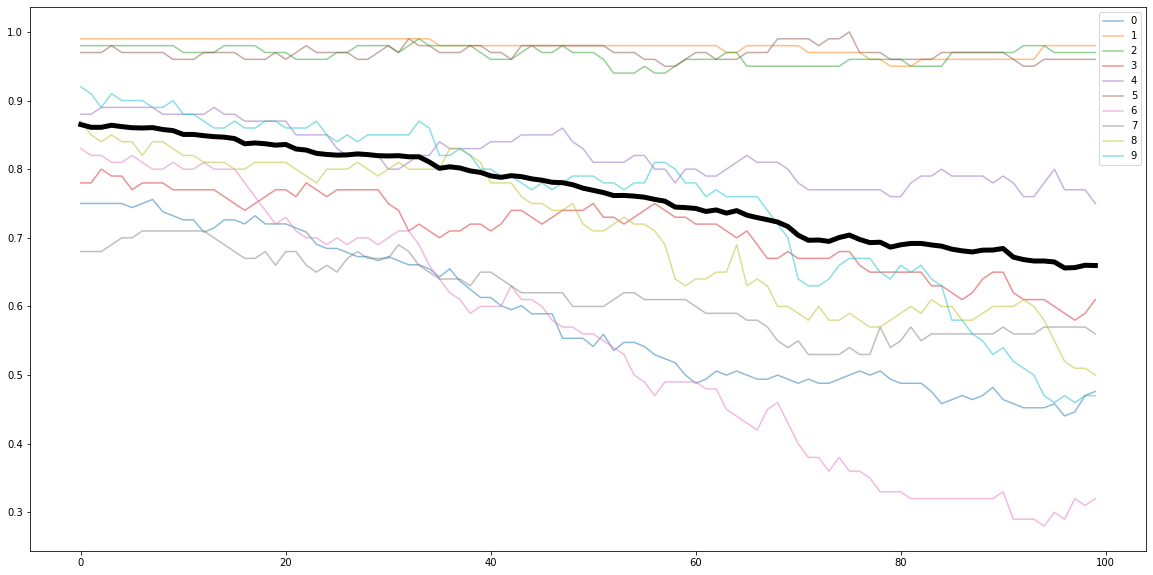

In [21]:
plt.figure(figsize=(20,10))
for i, k in enumerate(tot_score.keys()):
    plt.plot(np.array(tot_score[k]).mean(axis=0), alpha=.5, label=k)
    
    if i == 0:
        total = np.array(tot_score[k]).mean(axis=0)
    else:
        total += np.array(tot_score[k]).mean(axis=0)
        
total /= 10
plt.plot(total, color='black', linewidth=5)
plt.legend()
# plt.xlim((0, 100))
# plt.ylim((0., 1.))
plt.show()